<a href="https://colab.research.google.com/github/ManDes71/Rakuten_Text_Classification_TensorFlow/blob/main/modele_rnn_lemmatisation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Le NLTK, ou Natural Language Toolkit, est une suite de bibliothèques logicielles et de programmes. Elle est conçue pour le traitement naturel symbolique et statistique du langage anglais en langage Python. C’est l’une des bibliothèques de traitement naturel du langage les plus puissantes.**

**La technique de *Lemmatisation* est un processus algorithmique permettant de trouver le lemme d’un mot en fonction de son sens. Il s’agit de l’analyse morphologique des mots, visant à supprimer ses affixes. Sur NTLK, la fonction morph native de WordNet est utilisée pour la Lemmatisation.**

**Il est possible d’effectuer la Lemmatisation avec ou sans « POS tag » ou « part-of-speech tag ». Cette dernière méthode consiste à assigner un tag (une étiquette) à chaque mot afin d’accroître l’exactitude du mot dans le contexte de l’ensemble de données. Cette étiquette sert par exemple à indiquer si le mot est un verbe ou un adjectif, pour quoi le système sache quel affixe ajouter au lemme.**

***Google Colab -> Cette cellule est à executer (1 fois) pour le cloner le dépot en local***  
il est possible que google colab vous demande re demarrer la session

In [ ]:
!git clone https://github.com/ManDes71/Rakuten_Text_Classification_TensorFlow.git

Cloning into 'Rakuten_Text_Classification_TensorFlow'...
remote: Enumerating objects: 586, done.
remote: Counting objects: 100% (222/222), done.
remote: Compressing objects: 100% (96/96), done.
remote: Total 586 (delta 188), reused 132 (delta 126), pack-reused 364
Receiving objects: 100% (586/586), 41.76 MiB | 7.02 MiB/s, done.
Resolving deltas: 100% (383/383), done.
Updating files: 100% (33/33), done.


**Google Colab -> Cette cellule est à executer (2 fois) pour installer les bibliothèques nécessaires**  
You must restart the runtime in order to use newly installed versions.

In [ ]:
import sys
sys.path.append('/content/Rakuten_Text_Classification_TensorFlow')
!pip install -r /content/Rakuten_Text_Classification_TensorFlow/requirements.txt

In [ ]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from keras.optimizers import SGD,Adam
from tensorflow.keras.utils import to_categorical

import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')

if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, Dense, GlobalAveragePooling1D, RNN, GRUCell, Dropout

from nltk.tokenize import PunktSentenceTokenizer
from nltk.tokenize.regexp import RegexpTokenizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import SVC
from sklearn.metrics import f1_score, make_scorer,accuracy_score,classification_report
import nltk
import re
from sklearn import svm
import unicodedata
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import swifter

# set the max columns to none
pd.set_option('display.max_columns', None)

In [ ]:
MAXLEN = 600
NUM_WORDS = 70000
EMBEDDING_DIM = 200

In [ ]:
import configparser
import sys
#sys.path.append('../src')
sys.path.append('/content/Rakuten_Text_Classification_TensorFlow/src')
import Bibli_DataScience_3_3 as ds
config = configparser.ConfigParser()
config.read('Rakuten_config_colab.ini')

section :  ['DOSSIER', 'FICHIER']


[]

In [ ]:

import pandas as pd

# lecture des données sources d'entrainement
df_feats=pd.read_csv(ds.get_RACINE_DOSSIER() + 'X_train_update.csv')

# lecture des données cibles d'entrainement
df_target=pd.read_csv(ds.get_RACINE_DOSSIER() + 'Y_train_CVw08PX.csv')


# création d'un dataframe globale -  jointure
df=df_feats.merge(df_target,on='Unnamed: 0',how='inner')
df.rename(columns={'Unnamed: 0': 'Id'}, inplace=True)

# récupération du fichier df_langue.csv
df_langue=pd.read_csv(ds.get_RACINE_DOSSIER() + 'df_langue.csv')
df=df.merge(df_langue.drop(['Unnamed: 0','prdtypecode'], axis=1),on='Id',how='inner')

Lcat=df_target.sort_values(by='prdtypecode')['prdtypecode'].unique()


nomenclature=pd.read_csv(ds.get_RACINE_DOSSIER() + 'NOMENCLATURE.csv',header=0,encoding='utf-8',sep=';',index_col=0)
catdict=nomenclature.to_dict()['definition']

#
stopwordFR = pd.read_csv(ds.get_RACINE_DOSSIER() + 'stopwords_FR_02.csv')
stop_words = stopwordFR['MOT'].tolist()
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
df_feats

,Unnamed: 0,designation,description,productid,imageid
0,0,Olivia: Personalisiertes Notizbuch / 150 Seite...,NaN,3804725264,1263597046
1,1,Journal Des Arts (Le) N° 133 Du 28/09/2001 - L...,NaN,436067568,1008141237
2,2,Grand Stylet Ergonomique Bleu Gamepad Nintendo...,PILOT STYLE Touch Pen de marque Speedlink est ...,201115110,938777978
3,3,Peluche Donald - Europe - Disneyland 2000 (Mar...,NaN,50418756,457047496
4,4,La Guerre Des Tuques,Luc a des id&eacute;es de grandeur. Il veut or...,278535884,1077757786
...,...,...,...,...,...
84911,84911,The Sims [ Import Anglais ],NaN,206719094,941495734
84912,84912,Kit piscine acier NEVADA déco pierre Ø 3.50m x...,<b>Description complète :</b><br />Kit piscine...,3065095706,1188462883
84913,84913,Journal Officiel De La Republique Francaise N°...,NaN,440707564,1009325617
84914,84914,Table Basse Bois De Récupération Massif Base B...,<p>Cette table basse a un design unique et con...,3942400296,1267353403


In [ ]:
df_target

,Unnamed: 0,prdtypecode
0,0,10
1,1,2280
2,2,50
3,3,1280
4,4,2705
...,...,...
84911,84911,40
84912,84912,2583
84913,84913,2280
84914,84914,1560


In [ ]:
import pandas as pd

def combine_description_and_designation(row):
    partie_design = row['designation'] if isinstance(row['designation'], str) else ''
    partie_descrip = row['description'] if isinstance(row['description'], str) else ''
    return partie_design + ' ' + partie_descrip if len(partie_descrip) > 0 else partie_design

# Appliquer la fonction à chaque ligne
df_feats['phrases'] = df_feats.swifter.apply(combine_description_and_designation, axis=1)

Pandas Apply:   0%|          | 0/84916 [00:00<?, ?it/s]

# ETAPE 1 :
## Passage en minuscule
Dans un premier temps, nous transformons les majuscules en minuscules car les étapes suivantes sont sensibles à la casse
## ETAPE 2: Tokenisation
 Il s’agit de décomposer une phrase, et donc un document, en tokens. Un token est un élément correspondant à un mot ou une ponctuation, cependant de nombreux cas ne sont pas triviaux à traiter :
Les mots avec un trait d’union, exemple : peut être et peut-être qui ont des significations très différentes ;
Les dates et heures qui peuvent être séparées par des points, des slashs, des deux points ;
Les apostrophes ;
Les caractères spéciaux : émoticônes, formules mathématiques.

In [ ]:

def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn')

def preprocess_sentence(w):
    w = str(w)
    # Remplacer les entités HTML par des caractères spécifiques ou les supprimer
    replacements = {
        '&eacute;': 'e',
        '&amp;': '',    # Esperluette
        '&lt;': '',     # Inférieur à
        '&gt;': '',     # Supérieur à
        '&quot;': '',   # Guillemet double
        '&apos;': '',   # Apostrophe
        '&nbsp;': '',   # Espace insécable
        '&copy;': '',   # Droit d'auteur
        '&reg;': '',    # Marque déposée
        '&euro;': '',   # Symbole de l'euro
        '&rsquo;': '',
        '&agrave;': 'a',
        '&ccedil;': 'c',
        '&egrave;': 'e',
        '&iacute;': 'i',
        '&ntilde;': 'n',
        '&ouml;': 'o',
    }
    for entity, replacement in replacements.items():
        w = w.replace(entity, replacement)
    w = unicode_to_ascii(w.lower().strip())
    w = w.replace("n°", "??numero??")
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)
    w = re.sub(r"[^a-zA-Z?.!°]+", " ", w)
    w = re.sub(r'\b\w{0,2}\b', '', w)
    w = w.replace("? ? numero ? ?", "n°")


    # Suppression des stopwords
    mots = word_tokenize(w.strip())
    mots = [mot for mot in mots if mot not in stop_words]
    return ' '.join(mots).strip()

df_feats['WordRNN'] = df_feats['phrases'].swifter.apply(lambda x :preprocess_sentence(x))
df_feats.head()


Pandas Apply:   0%|          | 0/84916 [00:00<?, ?it/s]

,Unnamed: 0,designation,description,productid,imageid,phrases,WordRNN
0,0,Olivia: Personalisiertes Notizbuch / 150 Seite...,NaN,3804725264,1263597046,Olivia: Personalisiertes Notizbuch / 150 Seite...,olivia personalisiertes notizbuch seiten punkt...
1,1,Journal Des Arts (Le) N° 133 Du 28/09/2001 - L...,NaN,436067568,1008141237,Journal Des Arts (Le) N° 133 Du 28/09/2001 - L...,journal arts n° art marche salon art asiatique...
2,2,Grand Stylet Ergonomique Bleu Gamepad Nintendo...,PILOT STYLE Touch Pen de marque Speedlink est ...,201115110,938777978,Grand Stylet Ergonomique Bleu Gamepad Nintendo...,grand stylet ergonomique bleu gamepad nintendo...
3,3,Peluche Donald - Europe - Disneyland 2000 (Mar...,NaN,50418756,457047496,Peluche Donald - Europe - Disneyland 2000 (Mar...,peluche donald europe disneyland marionnette d...
4,4,La Guerre Des Tuques,Luc a des id&eacute;es de grandeur. Il veut or...,278535884,1077757786,La Guerre Des Tuques Luc a des id&eacute;es de...,guerre tuques luc idees grandeur . veut organi...


## ETAPE 3: Retrait des stopwords
Ensuite, nous retirons les mots appartenant aux stopwords. Il s’agit de listes de mots définies au préalable soit par l’utilisateur soit dans des librairies existantes. Ces listes se composent de mots qui n’apportent aucune information, qui sont en général très courants et donc présents dans la plupart des documents, par exemple : je, nous, avoir (le verbe et ses conjugaisons). La suppression de ces stopwords permet de ne pas polluer les représentations des documents afin qu’elle ne contienne que les mots représentatifs et significatifs. Ce “nettoyage” du texte peut aussi s’accompagner de la suppression d’autres éléments comme les nombres, les dates, la ponctuation etc.

In [ ]:
import string
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

nltk.download('punkt')
nltk.download('stopwords')

# Ajustement de la fonction preprocess_text
def preprocess_text(text):
    try:
        lang = detect(text)
    except:
        lang = "fr"  # Définit le français comme langue par défaut
    #text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Utilise le français comme langue de fallback pour la tokenisation
    tokens = word_tokenize(text, language='french' if lang not in ['en', 'es', 'de', 'nl', 'it', 'ca'] else lang)
    # Définit le français comme langue de fallback pour les stop words
    stop_words = set(stopwords.words({
        'en': 'english',
        'es': 'spanish',
        'de': 'german',
        'nl': 'dutch',
        'it': 'italian',
        'ca': 'french',  # Utilise explicitement le français pour le catalan
        'fr': 'french'
    }.get(lang, 'french')))  # Fallback sur le français pour toute autre langue non spécifiée

    tokens = [word for word in tokens if word not in stop_words]
    return tokens

# Supposons df_feats est votre DataFrame et 'concatenated' la colonne à traiter
# Appliquer preprocess_text à chaque valeur de la colonne 'concatenated'
df_feats['tokenized'] = df_feats['WordRNN'].swifter.apply(preprocess_text)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Pandas Apply:   0%|          | 0/84916 [00:00<?, ?it/s]

## ETAPE 4 : Groupement sémantique
Dès lors, nous disposons pour chaque document d’une liste “nettoyée” de mots porteurs de sens et séparés en tokens. Mais un mot peut être écrit au pluriel, au singulier ou avec différents accords et les verbes peuvent être conjugués à différents temps et personnes.
Nous devons donc réduire les différences grammaticales des mots en trouvant des formes communes. Pour ce faire, nous disposons de deux méthodes distinctes :
La stemmatisation, qui ne prend pas en compte le contexte de la phrase
La lemmatisation, qui prend en compte le contexte
### ETAPE 4.2 : La Lemmatisation
La lemmatisation, qui prend en considération le contexte dans lequel le mot est écrit, a pour but de trouver la forme canonique du mot, le lemme. Par conséquent, elle doit se faire après la transformation des lettres majuscules en minuscules et avant la tokenisation car les mots présents avant et après sont importants pour déterminer la nature du mot.
Le lemme correspond à l’infinitif des verbes et à la forme au masculin singulier des noms, adjectifs et articles. Par exemple cette méthode est capable de faire la différence entre “nous avions” : verbe avoir et “les avions” : le pluriel d’un avion.

In [ ]:
X_text_train, X_text_test, y_train, y_test = train_test_split(df_feats.tokenized, df_target.prdtypecode, test_size=0.2, random_state=1234)


In [ ]:
from nltk.stem import WordNetLemmatizer
import string

def preprocess_lemmer(tokens):
    lemmatizer = WordNetLemmatizer()

    preprocessed_tokens = []
    for token in tokens:
        # Conversion en minuscules et suppression de la ponctuation
        token = token.lower()
        token = token.translate(str.maketrans('', '', string.punctuation))
        # Lemmatisation
        lemmatized_token = lemmatizer.lemmatize(token)
        preprocessed_tokens.append(lemmatized_token)

    return preprocessed_tokens


In [ ]:
"""
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from langdetect import detect
import string

def preprocess_text(tokens):
    # Détection de la langue
    try:
        lang = detect(' '.join(tokens))
    except:
        lang = "fr"  # Langue par défaut
    # Adaptation des ressources linguistiques en fonction de la langue détectée
    if lang == 'en':
        stop_words = set(stopwords.words('english'))
    elif lang == 'es':
        stop_words = set(stopwords.words('spanish'))
    elif lang == 'de':
        stop_words = set(stopwords.words('german'))
    elif lang == 'nl':
        stop_words = set(stopwords.words('dutch'))
    elif lang == 'it':
        stop_words = set(stopwords.words('italian'))
    elif lang == 'ca':
        stop_words = set(stopwords.words('french'))
    else:
        stop_words = set(stopwords.words('french'))

    lemmatizer = WordNetLemmatizer()

    preprocessed_tokens = []
    for token in tokens:
        # Conversion en minuscules et suppression de la ponctuation
        token = token.lower()
        token = token.translate(str.maketrans('', '', string.punctuation))
        # Lemmatisation et suppression des stopwords
        if token not in stop_words and token != '':
            # Le WordNetLemmatizer nécessite les tags POS, mais ici nous utilisons une forme simplifiée sans eux
            lemmatized_token = lemmatizer.lemmatize(token)
            preprocessed_tokens.append(lemmatized_token)

    return preprocessed_tokens
"""

### ETAPE 5 : Word Embedding
 Le word embedding (plongement de mots) désigne un ensemble de méthode d’apprentissage visant à représenter les mots d’un texte par des vecteurs de nombres réels.
 le word embedding est capable en réduisant la dimension de capturer le contexte, la similarité sémantique et syntaxique (genre, synonymes, …) d’un mot. Par exemple, on pourrait s’attendre à ce que les mots « chien » et « chat » soient représentés par des vecteurs relativement peu distants dans l’espace vectoriel où sont définis ces vecteurs.

Comme pour les images, nous souhaitons que ça soit le modèle qui choisisse les caractéristiques les plus pertinentes représentant le mot. Par exemple, la caractéristique « être vivant » pourrait être intéressante pour différencier « chien » et « ordinateur », et rapprocher « chien » et « chat ».

In [ ]:
# Application de la fonction de prétraitement adaptée
X_text_train_preprocessed = [preprocess_lemmer(tokens) for tokens in X_text_train]
X_text_test_preprocessed = [preprocess_lemmer(tokens) for tokens in X_text_test]

# Puis, continuez avec la tokenisation (dans ce cas, la re-tokenisation) et le padding
tokenizer = Tokenizer()
tokenizer.fit_on_texts([' '.join(tokens) for tokens in X_text_train_preprocessed])


X_train = tokenizer.texts_to_sequences([' '.join(tokens) for tokens in X_text_train_preprocessed])
X_test = tokenizer.texts_to_sequences([' '.join(tokens) for tokens in X_text_test_preprocessed])


X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, maxlen=MAXLEN, padding='post', truncating='post')
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, maxlen=MAXLEN, padding='post', truncating='post')

print("Séquences tokenisées, stemmées et paddées :")


Séquences tokenisées, stemmées et paddées :


In [ ]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
label_encoder = LabelEncoder()
y_classes_converted = label_encoder.fit_transform(y_train)
#y_classes_train = label_encoder.transform(y_train)
# Maintenant, utilisez to_categorical
y_train_Network = to_categorical(y_classes_converted)
y_classes_converted = label_encoder.transform(y_test)
#y_classes_test = label_encoder.transform(y_test)
# Maintenant, utilisez to_categorical
y_test_Network = to_categorical(y_classes_converted)
print(y_train_Network.shape)
print(y_test_Network.shape)

(67932, 27)
(16984, 27)


In [ ]:
from tensorflow.keras.layers import  Dropout ,Conv1D,Flatten,Bidirectional,GRU,BatchNormalization

In [ ]:
vocab_size = len(tokenizer.word_index) + 1  # Taille du vocabulaire
embedding_dim = EMBEDDING_DIM  # Dimension de l'espace d'embedding
max_length = MAXLEN  # Déjà calculé lors du prétraitement
num_categories = 27  # Nombre de catégories

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
model.add(Conv1D(filters=32, kernel_size=8, activation='relu'))
# Ajout d'une couche GRU
model.add(GRU(128, return_sequences=True))
model.add(GlobalAveragePooling1D())
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))  # Augmentation du taux de dropout pour réduire le surajustement
model.add(Dense(num_categories, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 600, 200)          21571800  
                                                                 
 conv1d (Conv1D)             (None, 593, 32)           51232     
                                                                 
 gru (GRU)                   (None, 593, 128)          62208     
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 256)               33024     
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                          

In [ ]:
from tensorflow.keras import callbacks
lr_plateau = callbacks.ReduceLROnPlateau(monitor = 'val_loss',
                            patience=4,
                            factor=0.5,
                            verbose=1,
                            mode='min')

In [ ]:
model.compile(optimizer=Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Entraînement
training_history = model.fit(X_train, y_train_Network, epochs=5, validation_split=0.2,callbacks=[lr_plateau])  # Ajustez selon vos besoins
# Évaluation
loss, accuracy = model.evaluate(X_test, y_test_Network)
print(f'Loss: {loss}, Accuracy: {accuracy}')

Epoch 1/5
1699/1699 [==============================] - 2286s 1s/step - loss: 1.2891 - accuracy: 0.6256 - val_loss: 0.7673 - val_accuracy: 0.7747 - lr: 0.0010
Epoch 2/5
1699/1699 [==============================] - 2263s 1s/step - loss: 0.5165 - accuracy: 0.8509 - val_loss: 0.7306 - val_accuracy: 0.7944 - lr: 0.0010
Epoch 3/5
1699/1699 [==============================] - 2304s 1s/step - loss: 0.2578 - accuracy: 0.9246 - val_loss: 0.8123 - val_accuracy: 0.7975 - lr: 0.0010
Epoch 4/5
1699/1699 [==============================] - 2287s 1s/step - loss: 0.1397 - accuracy: 0.9601 - val_loss: 0.9330 - val_accuracy: 0.7968 - lr: 0.0010
Epoch 5/5
531/531 [==============================] - 102s 192ms/step - loss: 1.0593 - accuracy: 0.7939
Loss: 1.059293508529663, Accuracy: 0.7938647866249084


In [ ]:
predictions = model.predict(X_test)
y_pred = np.argmax(predictions, axis=1)
test_pred_original=label_encoder.inverse_transform(y_pred)
test_pred_original

531/531 [==============================] - 104s 195ms/step


array([2522, 1920, 2280, ..., 2583,   40, 2462])

In [ ]:
train_acc = training_history.history['accuracy']
val_acc = training_history.history['val_accuracy']
tloss = training_history.history['loss']
tvalloss=training_history.history['val_loss']

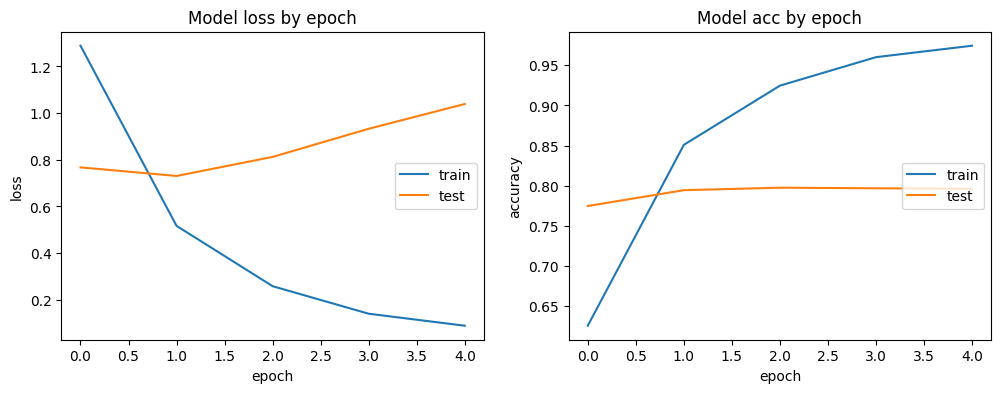

In [ ]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(tloss)
plt.plot(tvalloss)
plt.title('Model loss by epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='right')



plt.subplot(122)
plt.plot(train_acc)
plt.plot(val_acc)
plt.title('Model acc by epoch')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='right');

### Rapport de classification

In [ ]:

y_test_original=y_test
# On évalue le niveau de précision de notre prédiction.
print("Précision de la prédiction:", accuracy_score(y_test_original, test_pred_original)*100, '%')

print("Evaluation détaillée de la Classification par RDF :\n \n" ,
      (classification_report(y_test_original, test_pred_original)))

Précision de la prédiction: 79.38648139425342 %
Evaluation détaillée de la Classification par RDF :
 
               precision    recall  f1-score   support

          10       0.46      0.46      0.46       643
          40       0.68      0.63      0.65       503
          50       0.80      0.83      0.82       319
          60       0.97      0.83      0.89       179
        1140       0.75      0.74      0.75       545
        1160       0.92      0.82      0.87       793
        1180       0.48      0.55      0.51       144
        1280       0.66      0.70      0.68      1002
        1281       0.59      0.55      0.57       408
        1300       0.96      0.91      0.94       993
        1301       0.88      0.91      0.89       162
        1302       0.74      0.81      0.77       514
        1320       0.80      0.76      0.78       664
        1560       0.81      0.83      0.82       993
        1920       0.87      0.93      0.90       832
        1940       0.79      0.7

In [ ]:
import pandas as pd
df_test = pd.DataFrame({'tokenized': X_text_test, 'prdtypecode': y_test})
df_test['predict']=test_pred_original
df_test.head()

,tokenized,prdtypecode,predict
66047,"[stabilo, lot, stylos, feutre, film, ohpen, un...",2522,2522
29942,"[housse, fauteuil, integrale, elastique, prote...",1920,1920
58440,"[miroir, sprint, n°, campionnissimo, valet]",2280,2280
55079,"[brisons, glace, cold, hearted, icecrown]",1160,40
11424,"[little, prince, resine, prince, accueil, tabl...",2060,2060


### Tableau des 5 classes les plus prédites pour chaque classe réélle

In [ ]:
for c in Lcat:
    print(c,'   ------   ', catdict[c] )
    print(df_test[df_test['prdtypecode']==c]['predict'].value_counts(normalize=True)[:5])

10    ------    livres
predict
10      0.463453
2403    0.202177
2280    0.102644
2705    0.083981
40      0.037325
Name: proportion, dtype: float64
40    ------    jeux video pour pc et consoles
predict
40      0.626243
10      0.083499
2462    0.043738
1281    0.039761
2403    0.037773
Name: proportion, dtype: float64
50    ------     accesoires jeux video
predict
50      0.833856
40      0.031348
1280    0.028213
2462    0.021944
1560    0.018809
Name: proportion, dtype: float64
60    ------    consoles de jeux video
predict
60      0.826816
2462    0.094972
50      0.039106
40      0.011173
1940    0.005587
Name: proportion, dtype: float64
1140    ------    produits derives “geeks” et figurines
predict
1140    0.744954
1280    0.099083
1180    0.020183
2060    0.018349
10      0.016514
Name: proportion, dtype: float64
1160    ------    cartes collectionables
predict
1160    0.822194
10      0.042875
2403    0.029004
40      0.025221
1140    0.022699
Name: proportion, dtype: float64

In [ ]:
top5_df = pd.DataFrame({'prdtypecode':y_test_original ,'predict': test_pred_original})

df_cross=pd.crosstab(top5_df['prdtypecode'], top5_df['predict'],normalize='index')
top5_df.head()

,prdtypecode,predict
66047,2522,2522
29942,1920,1920
58440,2280,2280
55079,1160,40
11424,2060,2060


In [ ]:
df_pred = pd.DataFrame()
for c in Lcat:
            s = df_cross.loc[c].sort_values(ascending=False)[:5]
            df_temp = pd.DataFrame([{'Categorie':c,'predict':s.index[0],'pourc':s.values[0],'predict2':s.index[1],'pourc2':s.values[1],'predict3':s.index[2],'pourc3':s.values[2]}])
            df_pred = pd.concat([df_pred, df_temp], ignore_index=True)


### Tableau des repartitions des **classes prédites** pour chaque **classe réelle**

In [ ]:
df_pred

,Categorie,predict,pourc,predict2,pourc2,predict3,pourc3
0,10,10,0.463453,2403,0.202177,2280,0.102644
1,40,40,0.626243,10,0.083499,2462,0.043738
2,50,50,0.833856,40,0.031348,1280,0.028213
3,60,60,0.826816,2462,0.094972,50,0.039106
4,1140,1140,0.744954,1280,0.099083,1180,0.020183
5,1160,1160,0.822194,10,0.042875,2403,0.029004
6,1180,1180,0.548611,1140,0.083333,1281,0.062500
7,1280,1280,0.701597,1281,0.070858,1140,0.047904
8,1281,1281,0.549020,1280,0.205882,1302,0.053922
9,1300,1300,0.913394,1280,0.049345,10,0.004028


### Tableau croisé

In [ ]:
df_cross

predict,10,40,50,60,1140,1160,1180,1280,1281,1300,1301,1302,1320,1560,1920,1940,2060,2220,2280,2403,2462,2522,2582,2583,2585,2705,2905
prdtypecode,,,,,,,,,,,,,,,,,,,,,,,,,,,
10,0.463453,0.037325,0.000000,0.000000,0.007776,0.010886,0.013997,0.020218,0.012442,0.004666,0.001555,0.003110,0.012442,0.000000,0.003110,0.004666,0.004666,0.003110,0.102644,0.202177,0.000000,0.003110,0.000000,0.001555,0.003110,0.083981,0.000000
40,0.083499,0.626243,0.017893,0.001988,0.023857,0.009940,0.021869,0.023857,0.039761,0.001988,0.000000,0.001988,0.003976,0.003976,0.000000,0.000000,0.003976,0.003976,0.011928,0.037773,0.043738,0.000000,0.000000,0.003976,0.000000,0.031809,0.001988
50,0.003135,0.031348,0.833856,0.000000,0.015674,0.003135,0.000000,0.028213,0.003135,0.000000,0.000000,0.009404,0.015674,0.018809,0.000000,0.000000,0.003135,0.000000,0.000000,0.000000,0.021944,0.006270,0.000000,0.000000,0.006270,0.000000,0.000000
60,0.000000,0.011173,0.039106,0.826816,0.005587,0.000000,0.000000,0.005587,0.005587,0.000000,0.000000,0.005587,0.000000,0.000000,0.000000,0.005587,0.000000,0.000000,0.000000,0.000000,0.094972,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1140,0.016514,0.014679,0.007339,0.000000,0.744954,0.016514,0.020183,0.099083,0.009174,0.005505,0.000000,0.001835,0.001835,0.000000,0.000000,0.000000,0.018349,0.000000,0.005505,0.009174,0.007339,0.011009,0.000000,0.007339,0.000000,0.003670,0.000000
1160,0.042875,0.025221,0.003783,0.000000,0.022699,0.822194,0.005044,0.002522,0.010088,0.000000,0.000000,0.002522,0.001261,0.000000,0.002522,0.000000,0.001261,0.000000,0.015132,0.029004,0.006305,0.003783,0.000000,0.000000,0.001261,0.002522,0.000000
1180,0.027778,0.048611,0.000000,0.000000,0.083333,0.013889,0.548611,0.020833,0.062500,0.000000,0.000000,0.013889,0.006944,0.000000,0.006944,0.006944,0.020833,0.000000,0.000000,0.048611,0.027778,0.013889,0.000000,0.013889,0.000000,0.027778,0.006944
1280,0.008982,0.008982,0.010978,0.000000,0.047904,0.001996,0.010978,0.701597,0.070858,0.018962,0.000000,0.037924,0.025948,0.004990,0.002994,0.000998,0.010978,0.000998,0.003992,0.006986,0.002994,0.012974,0.000000,0.003992,0.000998,0.000998,0.000998
1281,0.024510,0.024510,0.002451,0.002451,0.002451,0.017157,0.024510,0.205882,0.549020,0.000000,0.004902,0.053922,0.009804,0.000000,0.000000,0.002451,0.002451,0.002451,0.004902,0.012255,0.012255,0.014706,0.007353,0.000000,0.000000,0.019608,0.000000


### Tableau des 5 classes les plus prédites pour chaque classe réélle avec libellés

In [ ]:
for c in Lcat:
    print(c,'   ------   ', catdict[c] )
    s=df_cross.loc[c].sort_values(ascending=False)[:5]
    for index, value in s.items():
        print(f"  : {index},  : {np.round(value*100,2)} % , {catdict[index]}")

10    ------    livres
  : 10,  : 46.35 % , livres
  : 2403,  : 20.22 % , livres et bds
  : 2280,  : 10.26 % , magazines
  : 2705,  : 8.4 % , bds et livres
  : 40,  : 3.73 % , jeux video pour pc et consoles
40    ------    jeux video pour pc et consoles
  : 40,  : 62.62 % , jeux video pour pc et consoles
  : 10,  : 8.35 % , livres
  : 2462,  : 4.37 % , consoles de jeux video et jeux videos
  : 1281,  : 3.98 % , jeux de societe/cartes
  : 2403,  : 3.78 % , livres et bds
50    ------     accesoires jeux video
  : 50,  : 83.39 % ,  accesoires jeux video
  : 40,  : 3.13 % , jeux video pour pc et consoles
  : 1280,  : 2.82 % , jouets, peluches, poupees
  : 2462,  : 2.19 % , consoles de jeux video et jeux videos
  : 1560,  : 1.88 % , Mobilier et produits decoration/rangement pour la maison
60    ------    consoles de jeux video
  : 60,  : 82.68 % , consoles de jeux video
  : 2462,  : 9.5 % , consoles de jeux video et jeux videos
  : 50,  : 3.91 % ,  accesoires jeux video
  : 40,  : 1.12 % , 

### Matrice de confusion

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test_original, test_pred_original)
print(cm[:10,:10])
print('*************************************************')
print(cm[10:20,10:20])
print('*************************************************')
print(cm[20:,20:])

[[298  24   0   0   5   7   9  13   8   3]
 [ 42 315   9   1  12   5  11  12  20   1]
 [  1  10 266   0   5   1   0   9   1   0]
 [  0   2   7 148   1   0   0   1   1   0]
 [  9   8   4   0 406   9  11  54   5   3]
 [ 34  20   3   0  18 652   4   2   8   0]
 [  4   7   0   0  12   2  79   3   9   0]
 [  9   9  11   0  48   2  11 703  71  19]
 [ 10  10   1   1   1   7  10  84 224   0]
 [  4   3   3   0   3   3   0  49   1 907]]
*************************************************
[[147   5   2   0   0   0   0   0   0   0]
 [  5 418   5   1   0   0   2   2   0   2]
 [  2  16 503  21  13   3  24   0   3   4]
 [  0   3  14 822  37   3  65   0   0   1]
 [  0   0   7  17 776   0  21   1   0   0]
 [  1   3   2   3   2 124   0   1   1   3]
 [  0   8  21  46  36   1 771   6   2   2]
 [  2   1   6   1   2   5   5 138   0   0]
 [  0   0   0   2   0   0   0   0 762  82]
 [  0   1   2   1   0   1   0   1  98 687]]
*************************************************
[[ 228    0    0    0    0    0    0]


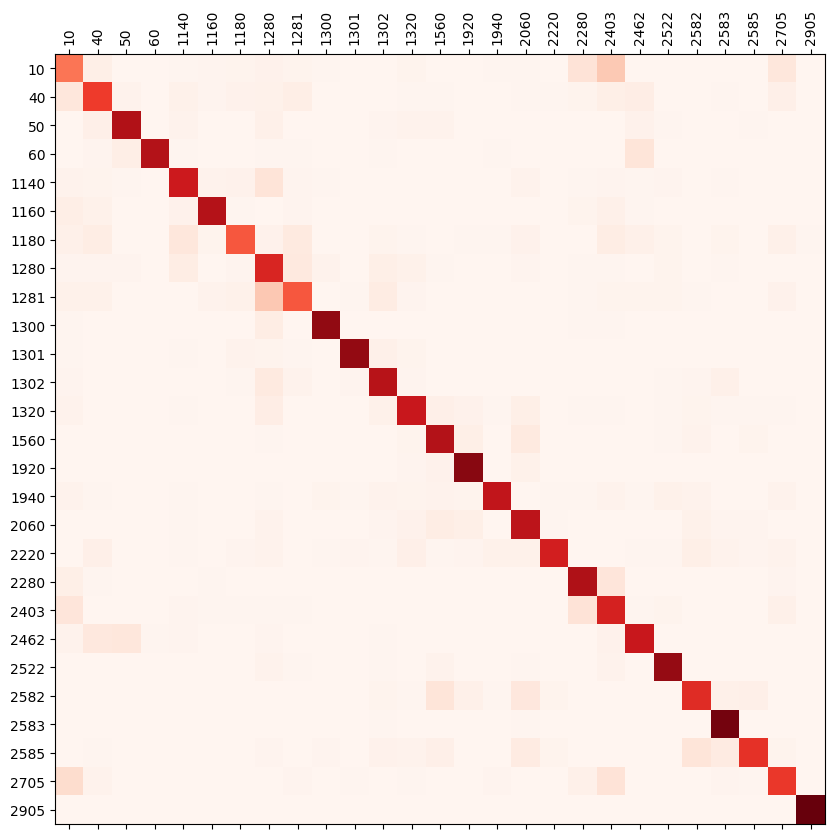

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
cm_normalized = cm.astype('float') / (cm.sum(axis=1)[:, np.newaxis])
#cm_normalized=cm.div(cm.sum(axis=1), axis=0)
cax = ax.matshow(cm_normalized, cmap='Reds')
plt.xticks(range(27),catdict,rotation=90)
plt.yticks(range(27),catdict,rotation=0)
plt.show()

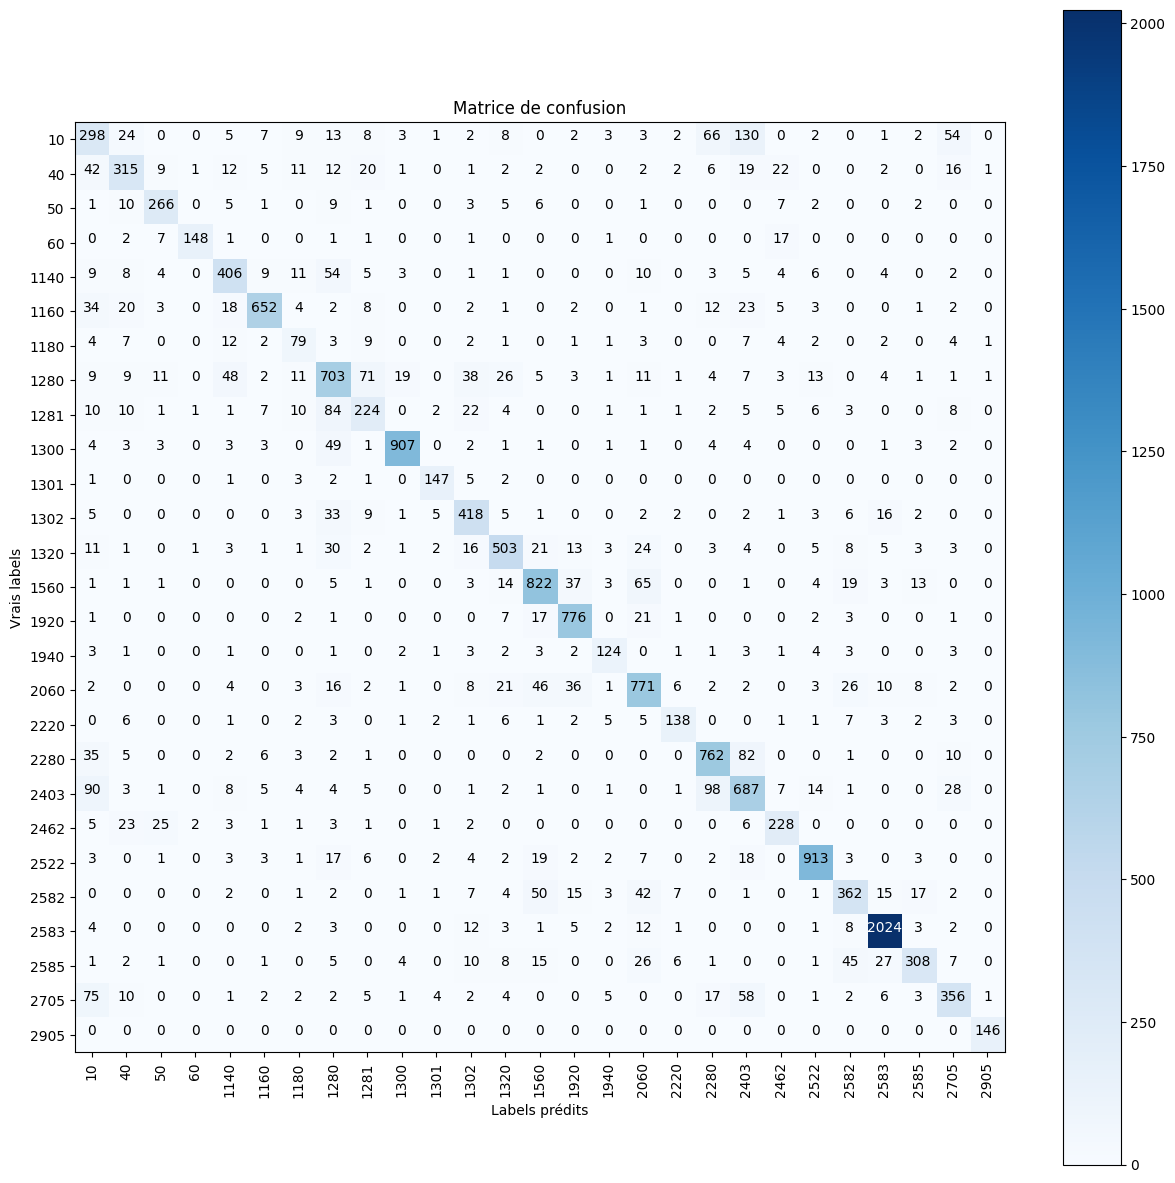

In [ ]:
import itertools



# Calcul de la matrice de confusion
cnf_matrix = confusion_matrix(y_test_original, test_pred_original, labels=sorted(list(set(y_test_original))))

# Définition des classes
classes = sorted(list(set(y_test_original)))

# Création et configuration de la figure
plt.figure(figsize=(15, 15))
plt.imshow(cnf_matrix, interpolation='nearest', cmap='Blues')
plt.title("Matrice de confusion")
plt.colorbar()

# Configuration des ticks
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=90)
plt.yticks(tick_marks, classes)

# Annotation de chaque cellule de la matrice de confusion
for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
    plt.text(j, i, cnf_matrix[i, j],
             horizontalalignment="center",
             color="white" if cnf_matrix[i, j] > (cnf_matrix.max() / 2) else "black")

# Labels pour les axes
plt.ylabel('Vrais labels')
plt.xlabel('Labels prédits')

# Affichage de la matrice de confusion
plt.show()

## Etude des catégories 10 ; 2280 ; 2403 ; 2705

In [ ]:
df_livres=df_test[df_test['prdtypecode'].isin([10,2280,2403,2705])]
df_livres.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3072 entries, 58440 to 46826
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   tokenized    3072 non-null   object
 1   prdtypecode  3072 non-null   int64 
 2   predict      3072 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 96.0+ KB


### Tableau des 5 classes les plus prédites pour chaque classe réélle

In [ ]:

for c in [10,2280,2403,2705]:
    print(c,'   ------   ', catdict[c] )
    print(df_livres[df_livres['prdtypecode']==c]['predict'].value_counts(normalize=True)[:5])

10    ------    livres
predict
10      0.463453
2403    0.202177
2280    0.102644
2705    0.083981
40      0.037325
Name: proportion, dtype: float64
2280    ------    magazines
predict
2280    0.836443
2403    0.090011
10      0.038419
2705    0.010977
1160    0.006586
Name: proportion, dtype: float64
2403    ------    livres et bds
predict
2403    0.714880
2280    0.101977
10      0.093652
2705    0.029136
2522    0.014568
Name: proportion, dtype: float64
2705    ------    bds et livres
predict
2705    0.639138
10      0.134650
2403    0.104129
2280    0.030521
40      0.017953
Name: proportion, dtype: float64


### Répartition des 20 mots les plus présents sur l'ensemble de ces catégories

In [ ]:
import pandas as pd
from collections import Counter

# Étape 1 : Identifier les 20 mots les plus fréquents
all_words = sum(df_livres['tokenized'].tolist(), [])
global_word_counts = Counter(all_words)
top_20_words = global_word_counts.most_common(20)

# Étape 2 : Calculer le nombre d'occurrences de chaque mot pour chaque classe et globalement
# Initialiser les données pour le DataFrame
data = {"Word": [word for word, count in top_20_words], "Total": [count for word, count in top_20_words]}
class_ids = df_livres['prdtypecode'].unique()

# Calculer les occurrences par classe pour chaque mot
for class_id in class_ids:
    data[class_id] = []
    for word, _ in top_20_words:
        word_count = sum(row.count(word) for row in df_livres[df_livres['prdtypecode'] == class_id]['tokenized'])
        data[class_id].append(word_count)

# Étape 3 : Créer le DataFrame
df_word_counts = pd.DataFrame(data)
df_word_counts.set_index("Word", inplace=True)

# Afficher le DataFrame
print(df_word_counts)
df_total_livres=df_word_counts

            Total  2280  2705  2403  10
Word                                   
n°            962   763     4   151  44
lot           426     0     0   426   0
vie           231    33   151    29  18
livres        221     5    13   189  14
monde         179    54   106    14   5
tome          170     6    58    66  40
france        160    73    35    33  19
livre         157     3    83    34  37
cette         149     3   142     2   2
histoire      141    24    70    28  19
temps         108     9    74    14  11
paris         102    55    26    15   6
collection    100    10    16    58  16
jean           97    39    21    25  12
journal        96    66     7    16   7
homme          96     6    77     6   7
edition        96     4     9    40  43
bien           95     7    85     2   1
deux           92    19    54    14   5
entre          92     6    73     7   6


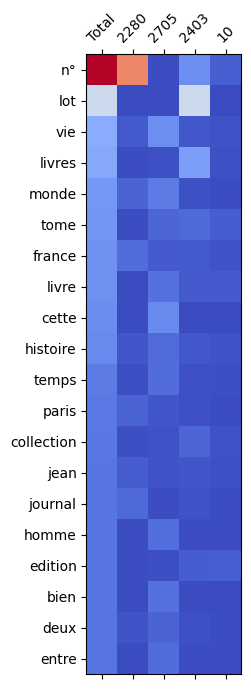

In [ ]:
fig, ax = plt.subplots(figsize=(2,20))
cax = ax.matshow(df_total_livres.iloc[0:20], cmap = 'coolwarm')
plt.xticks(range(5),(df_total_livres.columns.tolist()),rotation=45)
plt.yticks(range(20),df_total_livres.iloc[0:20].index,rotation=0)
plt.show()

## Etude des catégories 1280,1281

In [ ]:
df_jouets=df_test[df_test['prdtypecode'].isin([1280,1281])]

### Tableau des 5 classes les plus prédites pour chaque classe réélle

In [ ]:
for c in [1280,1281]:
    print(c,'   ------   ', catdict[c] )
    print(df_jouets[df_jouets['prdtypecode']==c]['predict'].value_counts(normalize=True)[:5])

1280    ------    jouets, peluches, poupees
predict
1280    0.701597
1281    0.070858
1140    0.047904
1302    0.037924
1320    0.025948
Name: proportion, dtype: float64
1281    ------    jeux de societe/cartes
predict
1281    0.549020
1280    0.205882
1302    0.053922
40      0.024510
10      0.024510
Name: proportion, dtype: float64


### Répartition des 20 mots les plus présents sur l'ensemble de ces catégories

In [ ]:
import pandas as pd
from collections import Counter

# Étape 1 : Identifier les 20 mots les plus fréquents
all_words = sum(df_jouets['tokenized'].tolist(), [])
global_word_counts = Counter(all_words)
top_20_words = global_word_counts.most_common(20)

# Étape 2 : Calculer le nombre d'occurrences de chaque mot pour chaque classe et globalement
# Initialiser les données pour le DataFrame
data = {"Word": [word for word, count in top_20_words], "Total": [count for word, count in top_20_words]}
class_ids = df_jouets['prdtypecode'].unique()

# Calculer les occurrences par classe pour chaque mot
for class_id in class_ids:
    data[class_id] = []
    for word, _ in top_20_words:
        word_count = sum(row.count(word) for row in df_jouets[df_jouets['prdtypecode'] == class_id]['tokenized'])
        data[class_id].append(word_count)

# Étape 3 : Créer le DataFrame
df_word_counts = pd.DataFrame(data)
df_word_counts.set_index("Word", inplace=True)

# Afficher le DataFrame
df_word_counts
df_total_livres=df_word_counts
df_word_counts

,Total,1280,1281
Word,,,
enfants,1350,940,410
jouet,594,445,149
jouets,593,435,158
bebe,546,416,130
taille,529,423,106
haute,432,337,95
jeu,415,184,231
couleur,372,289,83
toy,372,290,82


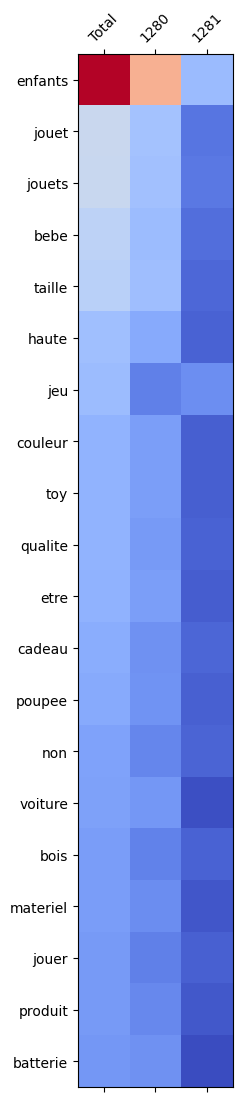

In [ ]:
fig, ax = plt.subplots(figsize=(2,20))
cax = ax.matshow(df_total_livres.iloc[0:20], cmap = 'coolwarm')
plt.xticks(range(3),(df_total_livres.columns.tolist()),rotation=45)
plt.yticks(range(20),df_total_livres.iloc[0:20].index,rotation=0)
plt.show()